## We are importing the custom API library package Recommenders for getting popularity based recommendations

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time
import Recommenders as Recommenders
%matplotlib inline

In [44]:
# Adding column names while reading the file

df=pd.read_csv('ratings_Electronics.csv',names=['userId','productId','ratings','timestamp'])

In [45]:
#Discarding timestamp column, as it is not needed

df.drop(columns='timestamp',inplace=True)

In [46]:
print(df.head())
len(df)

           userId   productId  ratings
0   AKM1MP6P0OYPR  0132793040      5.0
1  A2CX7LUOHB2NDG  0321732944      5.0
2  A2NWSAGRHCP8N5  0439886341      1.0
3  A2WNBOD3WNDNKT  0439886341      3.0
4  A1GI0U4ZRJA8WN  0439886341      1.0


7824482

In [47]:
#Finding if any null values are present in the datset

df.isnull().any().any()

False

In [48]:
#Finding users who have given atleast 50 ratings and extracting only them

print(df.shape)
counts1=df['userId'].value_counts()
df = df[df['userId'].isin(counts1[counts1 >= 50].index)]
print(df.shape)

(7824482, 3)
(125871, 3)


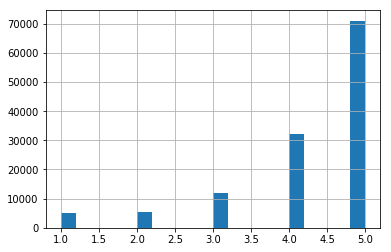

In [49]:
df['ratings'].hist(bins=20)

#We see that, 5 is the rating given for majority of the products, with rating 4 as the second

Fetching and counting the unique users from the dataset

In [50]:
users = df['userId'].unique()
len(users)

1540

In [51]:
#Splitting data into training and test sets

train_data, test_data = train_test_split(df, test_size = 0.20, random_state=0)
train_data.head()

,userId,productId,ratings
918719,A3IOQ7NVVLAUEE,B000FAKUE6,5.0
1411834,A141OPVE376YFI,B000UY3NR8,3.0
751249,AGX2K0FMS0IVL,B000BI655U,3.0
5303297,AX05DBU8IRUWY,B0064PKG3Q,4.0
2933011,ADLVFFE4VBT8,B002XJSB9S,4.0


### Creating an instance of popularity based recommender class

In [52]:
pm = Recommenders.popularity_recommender_py()
pm.create(train_data, 'userId', 'productId')

### Making some predictions using the popularity based model

In [53]:
user_id = users[20]
pm.recommend(user_id)

,userId,productId,score,Rank
33726,A341HCMGNZCBIT,B0088CJT4U,160,1.0
21503,A341HCMGNZCBIT,B003ES5ZUU,146,2.0
33101,A341HCMGNZCBIT,B007WTAJTO,134,3.0
9568,A341HCMGNZCBIT,B000N99BBC,128,4.0
33402,A341HCMGNZCBIT,B00829TIEK,118,5.0
34011,A341HCMGNZCBIT,B008DWCRQW,113,6.0
33398,A341HCMGNZCBIT,B00829THK0,104,7.0
19040,A341HCMGNZCBIT,B002R5AM7C,103,8.0
19238,A341HCMGNZCBIT,B002SZEOLG,95,9.0
24884,A341HCMGNZCBIT,B004CLYEDC,95,10.0


# User based Collaborative Filtering

In [54]:
from surprise import Dataset,Reader
reader = Reader(rating_scale=(1, 5))


In [55]:
data = Dataset.load_from_df(df[['userId','productId','ratings']], reader)

In [56]:
data

In [57]:
#Splitting data into training and test sets

from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.25,random_state=123)

In [58]:
type(trainset)

surprise.trainset.Trainset

### Training the model

In [59]:
from surprise import KNNWithMeans
from surprise import accuracy

In [60]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [61]:
testset[0:5]

[('A2ED50E3KWKUKW', 'B0015VW3BM', 5.0),
 ('AEL6CQNQXONBX', 'B00JK7Z83S', 5.0),
 ('A3V0YR50F1XSKP', 'B0051B4FP4', 5.0),
 ('A7Z2J9V37ABCO', 'B004GUS4WG', 5.0),
 ('APG2BHOAXPNEQ', 'B00BHZLHBI', 5.0)]

In [62]:
#Evaluating on the testset

test_pred = algo.test(testset)

# compute RMSE
accuracy.rmse(test_pred)

RMSE: 1.0632


1.0631962914101183

In [63]:
test_pred

[Prediction(uid='A2ED50E3KWKUKW', iid='B0015VW3BM', r_ui=5.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AEL6CQNQXONBX', iid='B00JK7Z83S', r_ui=5.0, est=4.263879325868881, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3V0YR50F1XSKP', iid='B0051B4FP4', r_ui=5.0, est=4.263879325868881, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A7Z2J9V37ABCO', iid='B004GUS4WG', r_ui=5.0, est=4.605263157894737, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='APG2BHOAXPNEQ', iid='B00BHZLHBI', r_ui=5.0, est=4.263879325868881, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3BVN2QBNPBHCR', iid='B00HRQB28Y', r_ui=5.0, est=4.977248438861664, details={'actual_k': 9, 'was_impossible': False}),
 Prediction(uid='A3OA4DV4L81N1D', iid='B0009P83EG', r_ui=5.0, est=4.263879325868881, details={'was_impossible': True, 'reason': 

## Getting top 5 product recommendations for each user

In [64]:
from collections import defaultdict

In [65]:
def get_top_p(test_pred, p):
    
    top_p = defaultdict(list)
    for uid, iid, true_x, est, _ in test_pred:
        top_p[uid].append((iid, est))
        
    for uid, df in top_p.items():
        df.sort(key = lambda x: x[1], reverse = True)
        top_p[uid] = df[:p]
        
    return top_p

In [66]:
get_top_p(test_pred, 5)

defaultdict(list,
            {'A2ED50E3KWKUKW': [('B0015VW3BM', 5),
              ('B0079M711S', 5),
              ('B00004XOM3', 5),
              ('B004UTQRHW', 5),
              ('B00E3K94T6', 5)],
             'AEL6CQNQXONBX': [('B00IRX1NXK', 5),
              ('B000068O3C', 5),
              ('B0038KLD50', 5),
              ('B00KVNY2KA', 4.999115700327479),
              ('B00E98O7GC', 4.992778254533345)],
             'A3V0YR50F1XSKP': [('B003LZYXYU', 4.794068736141907),
              ('B0039825LM', 4.6477272727272725),
              ('B000067SLZ', 4.6477272727272725),
              ('B005ARQV6U', 4.6477272727272725),
              ('B007C81JL2', 4.6477272727272725)],
             'A7Z2J9V37ABCO': [('B009OBCAW2', 5),
              ('B00B46XUQU', 5),
              ('B004RORMF6', 5),
              ('B004GUS4WG', 4.605263157894737),
              ('B00746YZS6', 4.605263157894737)],
             'APG2BHOAXPNEQ': [('B00BHZLHBI', 4.263879325868881),
              ('B0054OWT0G', 4.263

Popularity bases recommender systems provide recommendations based on the number of ratings got by each product and hence
it does not give personalised recommendations and irresepective of user background, it is going to show the same recommendations.


Collaborative filtering model recommends products based on user's
past preferences, new users will need to rate sufficient number of items to enable the system to capture their preferences
accurately for getting recommendations.